In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
df = pd.read_csv('C:/Users/visha/Downloads/archive (1)/fer2013.csv')
df.shape

(35887, 3)

In [3]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
df.Usage.value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [5]:
train = df[df['Usage']=='Training'].copy()
val   = df[df['Usage']=='PublicTest'].copy()
test  = df[df['Usage']=='PrivateTest'].copy()
print(f"train shape: {train.shape}, \nvalidation shape: {val.shape}, \ntest shape: {test.shape}")

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


In [6]:

train.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [7]:
labels = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = df['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(labels)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,547


In [31]:
emotion_counts['emotion'][0]

'Angry'

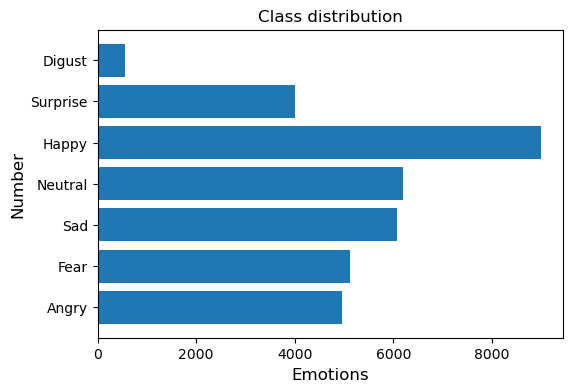

In [8]:
plt.figure(figsize=(6,4))
plt.barh(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

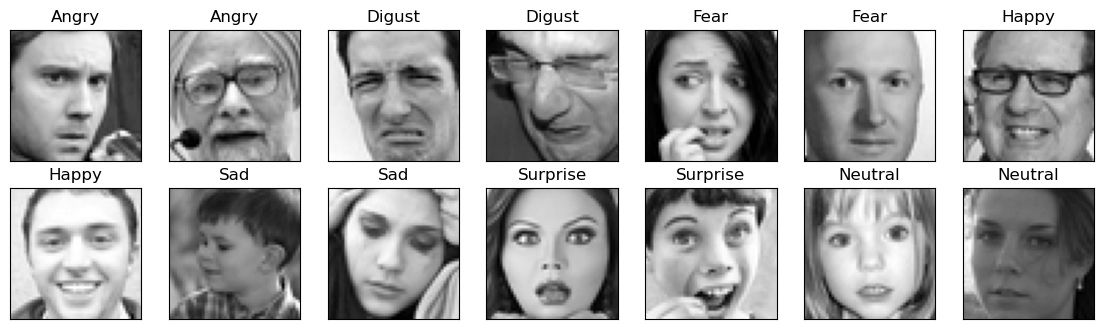

In [9]:
fig = plt.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(2):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(labels[label])

In [10]:
from keras.utils import to_categorical

In [11]:
def preprocess(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda x: np.array(x.split(), dtype='float32'))
    data_X = np.array(df['pixels'].tolist()).reshape(-1, 48, 48, 1)/255.0 
    data_Y = to_categorical(df['emotion'], 7)  
    print(dataName, f"_X shape: {data_X.shape}, ", dataName, f"_Y shape: {data_Y.shape}")
    return data_X, data_Y

train_X, train_Y = preprocess(train, "train") #training data
val_X, val_Y     = preprocess(val, "val") #validation data
test_X, test_Y   = preprocess(test, "test") #test data    


train _X shape: (28709, 48, 48, 1),  train _Y shape: (28709, 7)
val _X shape: (3589, 48, 48, 1),  val _Y shape: (3589, 7)
test _X shape: (3589, 48, 48, 1),  test _Y shape: (3589, 7)


In [12]:
# Import keras models
import tensorflow as tf
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
num_features = 64
width = 48
height = 48
num_classes = 7

In [14]:
# Define the CNN model
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))  # Assuming 7 different emotion classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,575,559 (6.01 MB)

 Trainable params: 1,573,575 (6.00 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [15]:
# Train the model on the training data
train_data = model.fit(train_X, train_Y, epochs = 50, verbose=1, validation_data = (val_X, val_Y))

Epoch 1/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 88s 85ms/step - accuracy: 0.2538 - loss: 2.2861 - val_accuracy: 0.3427 - val_loss: 1.8184
Epoch 2/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 66s 74ms/step - accuracy: 0.4263 - loss: 1.5050 - val_accuracy: 0.4132 - val_loss: 1.4985
Epoch 3/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 69s 77ms/step - accuracy: 0.4834 - loss: 1.3512 - val_accuracy: 0.4673 - val_loss: 1.4025
Epoch 4/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 69s 77ms/step - accuracy: 0.5132 - loss: 1.2849 - val_accuracy: 0.5082 - val_loss: 1.3091
Epoch 5/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 69s 77ms/step - accuracy: 0.5321 - loss: 1.2262 - val_accuracy: 0.5311 - val_loss: 1.2125
Epoch 6/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 66s 73ms/step - accuracy: 0.5474 - loss: 1.1846 - val_accuracy: 0.4558 - val_loss: 1.5447
Epoch 7/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 66s 73ms/step - accuracy: 0.5537 - loss: 1.1639 - val_accuracy: 0.5659 - val_loss: 1.1627
Epoch 8/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 67s 74ms/step - accuracy: 0.5807 - loss: 1.1101 - 

In [16]:
# Evaluate the model on the testing data
loss, accuracy = model.evaluate(test_X,test_Y)
print(loss)
print(accuracy)

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6305 - loss: 1.1998
1.153753638267517
0.6341599225997925


In [17]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
CNN Model Accuracy on test set: 0.6342


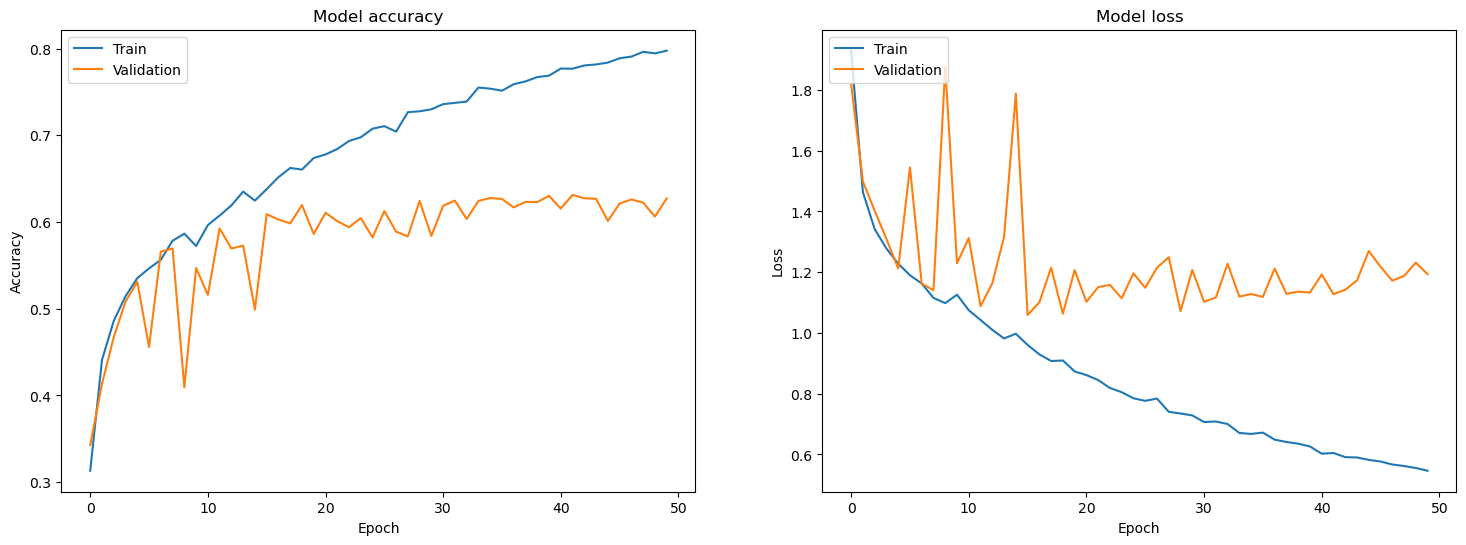

In [23]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))

axes[0].plot(train_data.history['accuracy'])
axes[0].plot(train_data.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(train_data.history['loss'])
axes[1].plot(train_data.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

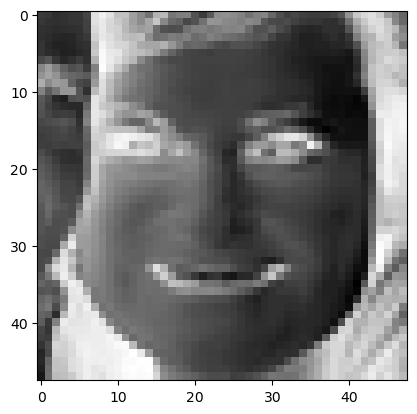

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
Our model says it is: Neutral
Actual emotion is:  Neutral


In [44]:
import random

idx = random.randrange(0,len(test_X))
plt.imshow(test_X[idx], cmap = plt.cm.binary)
plt.show()

predictions= model.predict([test_X])
print(f'Our model says it is:' ,emotion_counts['emotion'][np.argmax(predictions[idx])])
print('Actual emotion is: ', emotion_counts['emotion'][np.argmax(test_Y[idx])])